In [1]:
import deepxde as dde
import numpy as np
import matplotlib.pyplot as plt

Using backend: pytorch



In [ ]:
## Baseline model using deepxde

Compiling model...
'compile' took 0.000227 s

Training model...

Step      Train loss    Test loss     Test metric   
0         [4.39e+00]    [4.26e+00]    [1.37e+00]    
1000      [9.98e-02]    [1.00e-01]    [2.10e-01]    
2000      [9.29e-02]    [9.26e-02]    [2.02e-01]    
3000      [9.20e-02]    [9.15e-02]    [2.01e-01]    
4000      [9.13e-02]    [9.05e-02]    [1.99e-01]    
5000      [9.26e-02]    [9.15e-02]    [2.00e-01]    
6000      [9.05e-02]    [8.92e-02]    [1.98e-01]    
7000      [8.96e-02]    [8.82e-02]    [1.97e-01]    
8000      [8.54e-02]    [8.41e-02]    [1.92e-01]    
9000      [6.21e-02]    [6.16e-02]    [1.65e-01]    
10000     [3.97e-02]    [3.98e-02]    [1.32e-01]    
11000     [3.04e-02]    [3.05e-02]    [1.16e-01]    
12000     [2.17e-02]    [2.18e-02]    [9.80e-02]    
13000     [1.47e-02]    [1.48e-02]    [8.07e-02]    
14000     [1.26e-02]    [1.27e-02]    [7.47e-02]    
15000     [1.14e-02]    [1.15e-02]    [7.11e-02]    
16000     [5.43e-03]    [5.48e-03]

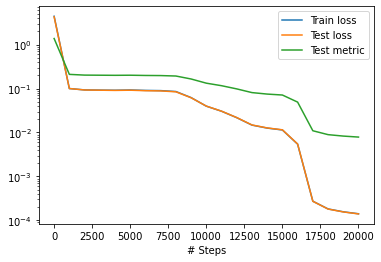

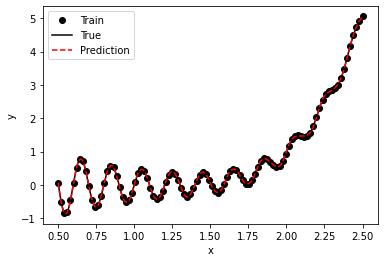

In [4]:
def func(x):
    return np.sin(10*np.pi*x)/(2*x) + (x-1)**4

geom = dde.geometry.Interval(0.5, 2.5)
num_train = 100
num_test = 1000
data = dde.data.Function(geom, func, num_train, num_test)

layer_size = [1] + [64] * 3 + [1]
activation = "tanh"
initializer = "Glorot uniform"
net = dde.nn.FNN(
    layer_size,
    activation,
    initializer,
)

model = dde.Model(data, net)
model.compile("adam", lr=1e-3, metrics=["l2 relative error"])
losshistory, train_state = model.train(epochs=20000)

dde.saveplot(losshistory, train_state, issave=True, isplot=True)

## Federated Learning

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import time
import copy
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import torchvision.transforms as transforms
import os
from typing import Any, Dict, List
import copy
import random

In [8]:
class Client:
    def __init__(self,
                 client_id: Any,
                 model: torch.nn.Module,
                 loss: torch.nn.modules.loss._Loss,
                 optimizer: torch.optim.Optimizer,
                 optimizer_conf: Dict,
                 batch_size: int,
                 epochs: int,
                 server=None) -> None:
        self.client_id = client_id
        self.model = model
        self.loss = loss
        self.optimizer = optimizer(self.model.parameters(), **optimizer_conf)
        self.batch_size = batch_size
        self.epochs = epochs
        self.server = server
        self.accuracy = None
        self.total_loss = None

        self.data = None
        self.data_loader = None

    def setData(self, data):
        self.data = data
        self.data_loader = torch.utils.data.DataLoader(self.data,
                                                       batch_size=self.batch_size,
                                                       shuffle=True)
        self.server.total_data += len(self.data)

    def update_weights(self):
        for eps in range(self.epochs):
            total_loss = 0
            total_batches = 0
            total_correct = 0

            for _, (feature, label) in enumerate(self.data_loader):
                feature = feature.to(device)
                label = label.to(device)
                
                y_pred = self.model(feature)
                
                loss = self.loss(y_pred, label)
                
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                total_loss += loss.item()
                total_batches += 1
                

            self.total_loss = total_loss / total_batches
        
        
        # self.accuracy = total_correct / (total_batches * self.batch_size)
        
class Server:
    def __init__(self,
                 model: torch.nn.Module,
                 loss: torch.nn.modules.loss._Loss,
                 optimizer: torch.optim.Optimizer,
                 optimizer_conf: Dict,
                 n_client: int,
                 chosen_prob: float ,
                 local_batch_size: int,
                 local_epochs: int) -> None:

        # global model info
        self.model = model
        self.loss = loss
        self.optimizer = optimizer
        self.optimizer_conf = optimizer_conf
        self.n_client = n_client
        self.local_batch_size = local_batch_size
        self.local_epochs = local_epochs
        self.total_data = 0

        # create clients
        self.client_pool: List[Client] = []
        self.create_client()
        self.chosen_prob = chosen_prob
        self.avg_loss = 0
        self.avg_acc = 0

    def create_client(self):
        # this function is reusable, so reset client pool is needed
        self.client_pool: List[Client] = []
        self.total_data = 0

        for i in range(self.n_client):
            model = copy.deepcopy(self.model)
            new_client = Client(client_id=i,
                                model=model,
                                loss=self.loss,
                                optimizer=self.optimizer,
                                optimizer_conf=self.optimizer_conf,
                                batch_size=self.local_batch_size,
                                epochs=self.local_epochs,
                                server=self)
            self.client_pool.append(new_client)

    def broadcast(self):
        model_state_dict = copy.deepcopy(self.model.state_dict())
        for client in self.client_pool:
            client.model.load_state_dict(model_state_dict)

    def aggregate(self):
        self.avg_loss = 0
        self.avg_acc = 0
        chosen_clients = random.sample(self.client_pool,
                                       int(len(self.client_pool) * self.chosen_prob))

        global_model_weights = copy.deepcopy(self.model.state_dict())
        for key in global_model_weights:
            global_model_weights[key] = torch.zeros_like(
                global_model_weights[key])

        for client in chosen_clients:
            client.update_weights()
#             print(f"Client {client.client_id}: Loss: {client.total_loss}")
            self.avg_loss += 1 / len(chosen_clients) * client.total_loss
            # self.avg_acc += 1 / len(chosen_clients) * client.accuracy
            local_model_weights = copy.deepcopy(client.model.state_dict())
            for key in global_model_weights:
                global_model_weights[key] += 1 / len(chosen_clients) * local_model_weights[key]

        self.model.load_state_dict(global_model_weights)

In [9]:
# Define NN
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(1,50)
        self.fc2 = nn.Linear(50,50)
        self.fc3 = nn.Linear(50,50)
        self.fc4 = nn.Linear(50,50)
        self.fc5 = nn.Linear(50,1)
    def forward(self, x):
        x = F.tanh(self.fc1(x))
        x = F.tanh(self.fc2(x))
        x = F.tanh(self.fc3(x))
        x = F.tanh(self.fc4(x))
        x = self.fc5(x)
        return x

In [10]:
from operator import itemgetter 

def assign_data(ratio, clients, dataloader, assignment): 
    """
    ratio: a list that contains the ratio of data assigned to each worker;
            each element should be <=1 and sum <=1
    clients: a list of Client class
    dataloader: torch.DataLoader
    assignment: string, "alternating", "random", "sequential" 
    """
    if assignment == "alternating":
        total_data = []
        labels = []
        for idx, (data, label) in enumerate(dataloader):
            total_data.append(data.detach().numpy())
            labels.append(label.detach().numpy())
        
        # create list for data assignment
        assign_data = [[]for i in range(len(ratio))]
        assign_label = [[]for i in range(len(ratio))]
        
        # assign data alternatingly till satisfy the ratio
        for i in range(len(total_data)):
            loc = i%len(ratio)
            while(len(assign_data[loc]) == ratio[loc]*len(total_data)):
                loc += 1
            assign_data[loc].append(np.array(total_data)[i,:])
            assign_label[loc].append(np.array(labels)[i,:])

        for j in range(len(ratio)):
            x = np.array(assign_data[j])
            y = np.array(assign_label[j])
            client_data = TensorDataset(torch.from_numpy(x.reshape((len(x)*len(x[0]),1))).float(),
                                                torch.from_numpy(y.reshape((len(y)*len(y[0]),1))).float())
            clients[j].setData(client_data)
      
    if assignment == "random":
        total_data = []
        labels = []
        for idx, (data, label) in enumerate(dataloader):
            total_data.append(data.detach().numpy())
            labels.append(label.detach().numpy())
        
        # create list for data assignment
        assign_data = []
        assign_label = []
        data_idx = [batch_idx for batch_idx,(data, label) in enumerate(train_loader)]
        
        # random assignment
        for i in range(len(ratio)):
            n = int(ratio[i]* len(data_idx))
            loc = random.sample(data_idx, n)
            tempx = np.array(itemgetter(*loc)(total_data))
            tempy = np.array(itemgetter(*loc)(labels))
            assign_data.append(tempx.reshape(len(tempx)* len(tempx[0]),1))
            assign_label.append(tempy.reshape(len(tempy)* len(tempy[0]),1))

        for j in range(len(ratio)):

            x = np.array(assign_data[j])
            y = np.array(assign_label[j])
            client_data = TensorDataset(torch.from_numpy(x.reshape((len(x)*len(x[0]),1))).float(),
                                                torch.from_numpy(y.reshape((len(y)*len(y[0]),1))).float())
            clients[j].setData(client_data)

    if assignment == "sequential":
        for j in range(len(ratio)):
            client_data = []
            tempx = []
            tempy = []
            left_idx = int(np.sum(ratio[:j])*len(loader))
            right_idx = left_idx + int(ratio[j]*len(loader))

            for batch_idx, (data,target) in enumerate(train_loader):
                if left_idx <= batch_idx < right_idx:
                    tempx.append(data.detach().numpy())
                    tempy.append(target.detach().numpy())
            x = np.array(tempx)
            y = np.array(tempy)
            client_data = TensorDataset(torch.from_numpy(x.reshape((len(x)*len(x[0]),1))).float(),
                                        torch.from_numpy(y.reshape((len(y)*len(y[0]),1))).float())
            clients[j].setData(client_data)
            
            

### parameters

In [11]:
# initialize parameters
torch.manual_seed(1)
n_client = 2
chosen_prob = 1
local_batch_size = 10
local_epochs = 3
epochs =15000
criteria = nn.MSELoss()
optimizer = optim.Adam
optimizer_conf = dict(
    lr=0.001,
#     momentum=0.9
)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = Net().to(device)

server = Server(
    model=model,
    loss=criteria,
    optimizer=optimizer,
    n_client=n_client,
    chosen_prob=chosen_prob,
    optimizer_conf=optimizer_conf,
    local_batch_size=local_batch_size,
    local_epochs=local_epochs
)

In [18]:
# Data preparation
def func(x):
    return np.sin(10*np.pi*x)/(2*x) + (x-1)**4

ntrain = 100
ntest = 1000
x = np.linspace(0.5, 2.5, ntrain)
y = func(x)
np.savetxt("train.txt", np.vstack((x, y)).T)
x = np.linspace(0.5, 2.5, ntest)
y = func(x)
np.savetxt("test.txt", np.vstack((x, y)).T)

In [19]:
# Load data
x_train = torch.from_numpy(np.loadtxt("train.txt")[:, :1]).float()
y_train = torch.from_numpy(np.loadtxt("train.txt")[:, 1:]).float()
x_test = torch.from_numpy(np.loadtxt("test.txt")[:, :1]).float()
y_test = torch.from_numpy(np.loadtxt("test.txt")[:, 1:]).float()

train = TensorDataset(x_train, y_train)
test = TensorDataset(x_test, y_test) 
train_loader = DataLoader(train, batch_size=10, shuffle=False)  
test_loader = DataLoader(test, batch_size=1000, shuffle=False)

### Data [0.5, 0.5]

In [444]:
clients = server.client_pool
ratio1 = [0.5, 0.5]
assign_data(ratio1, clients, dataloader = train_loader, assignment='alternating')

In [21]:
def test(federated_model):
    federated_model.eval()
    test_loss = 0
    for data, target in test_loader:
        output = federated_model(data)
        test_loss += F.mse_loss(output.view(-1), target, reduction='sum').item()
    test_loss /= len(test_loader.dataset)
    return test_loss
    

In [445]:

for epoch in range(epochs):
    server.aggregate()
    server.broadcast()
    with torch.no_grad():
        testloss = test(server.model)
    
    if epoch % 100 == 0:
        print("Epoch: {}, Overall_loss: {}, test_loss: {}".format(epoch, server.avg_loss, testloss))
        

/Users/apple/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-445-2b91ddb144e0>:6: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  test_loss += F.mse_loss(output.view(-1), target, reduction='sum').item()


Epoch: 0, Overall_loss: 1.4627431571483613, test_loss: 1818.9335
Epoch: 100, Overall_loss: 0.10154670216143132, test_loss: 3319.65575
Epoch: 200, Overall_loss: 0.10037483274936676, test_loss: 3382.2415
Epoch: 300, Overall_loss: 0.09731581211090087, test_loss: 3384.5035
Epoch: 400, Overall_loss: 0.09228853695094585, test_loss: 3369.142
Epoch: 500, Overall_loss: 0.08264269046485424, test_loss: 3478.79825
Epoch: 600, Overall_loss: 0.07305518426001073, test_loss: 3349.8105
Epoch: 700, Overall_loss: 0.04572516176849603, test_loss: 3338.2735
Epoch: 800, Overall_loss: 0.037748352624475956, test_loss: 3311.6255
Epoch: 900, Overall_loss: 0.031052044313400983, test_loss: 3443.782
Epoch: 1000, Overall_loss: 0.03198493830859661, test_loss: 3389.69225
Epoch: 1100, Overall_loss: 0.022430566046386956, test_loss: 3441.7705
Epoch: 1200, Overall_loss: 0.01675114412792027, test_loss: 3441.03275
Epoch: 1300, Overall_loss: 0.014725818391889335, test_loss: 3471.4935
Epoch: 1400, Overall_loss: 0.017226996179

Epoch: 11700, Overall_loss: 0.00046212295128498224, test_loss: 3409.27775
Epoch: 11800, Overall_loss: 0.0004029862844618037, test_loss: 3425.885
Epoch: 11900, Overall_loss: 0.0005995803738187532, test_loss: 3423.782
Epoch: 12000, Overall_loss: 0.0008831701154122128, test_loss: 3435.3315
Epoch: 12100, Overall_loss: 0.0017001375745167024, test_loss: 3348.9495
Epoch: 12200, Overall_loss: 0.0020692011574283244, test_loss: 3407.26525
Epoch: 12300, Overall_loss: 0.0009112252155318856, test_loss: 3387.435
Epoch: 12400, Overall_loss: 0.0004365371336461976, test_loss: 3426.354
Epoch: 12500, Overall_loss: 0.0010067794508358929, test_loss: 3425.2755
Epoch: 12600, Overall_loss: 0.00048416692807222715, test_loss: 3420.4355
Epoch: 12700, Overall_loss: 0.00026567181266727856, test_loss: 3425.38325
Epoch: 12800, Overall_loss: 0.0002455873574945144, test_loss: 3424.46875
Epoch: 12900, Overall_loss: 0.000276962730276864, test_loss: 3417.139
Epoch: 13000, Overall_loss: 0.00036587560607586055, test_loss: 

In [24]:
def L2_error(x, y):
    error1 = 0
    error2 = 0
    for i in range(len(x)):
        error1 += (x[i] - y[i]) ** 2
        error2 += (y[i]) ** 2
    return np.sqrt(error1) / np.sqrt(error2)

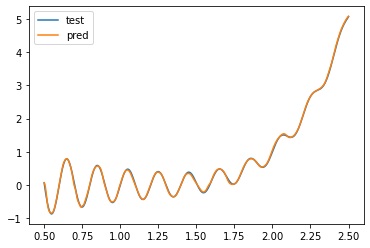

In [447]:
y_pred = model(x_test).detach().numpy()
plt.plot(np.loadtxt("test.txt")[:, :1], np.loadtxt("test.txt")[:, 1:], label='test')
plt.plot(np.loadtxt("test.txt")[:, :1], y_pred, label='pred')
plt.legend()

In [448]:
print(L2_error(y_pred, y_test.detach().numpy()))

[0.01728155]


In [449]:
np.savetxt("1D55.txt", y_pred)

### Data[0.4, 0.6]

In [450]:
model = Net().to(device)

server = Server(
    model=model,
    loss=criteria,
    optimizer=optimizer,
    n_client=n_client,
    chosen_prob=chosen_prob,
    optimizer_conf=optimizer_conf,
    local_batch_size=local_batch_size,
    local_epochs=local_epochs
)

clients = server.client_pool
ratio1 = [0.4, 0.6]
assign_data(ratio1, clients, dataloader = train_loader, assignment='alternating')


In [451]:
for epoch in range(epochs):
    server.aggregate()
    server.broadcast()
    with torch.no_grad():
        testloss = test(server.model)
    
    if epoch % 100 == 0:
        print("Epoch: {}, Overall_loss: {}, test_loss: {}".format(epoch, server.avg_loss, testloss))

/Users/apple/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-445-2b91ddb144e0>:6: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  test_loss += F.mse_loss(output.view(-1), target, reduction='sum').item()


Epoch: 0, Overall_loss: 1.083374487857024, test_loss: 1759.19875
Epoch: 100, Overall_loss: 0.12163608490178981, test_loss: 3683.967
Epoch: 200, Overall_loss: 0.10384095522264639, test_loss: 3636.3005
Epoch: 300, Overall_loss: 0.0992829737563928, test_loss: 3665.0315
Epoch: 400, Overall_loss: 0.0971596046971778, test_loss: 3843.31875
Epoch: 500, Overall_loss: 0.06934255516777435, test_loss: 3519.64775
Epoch: 600, Overall_loss: 0.10695260142286618, test_loss: 3529.36075
Epoch: 700, Overall_loss: 0.049358297915508345, test_loss: 3814.412
Epoch: 800, Overall_loss: 0.054892970249056816, test_loss: 3609.10225
Epoch: 900, Overall_loss: 0.044325783072660364, test_loss: 3699.44075
Epoch: 1000, Overall_loss: 0.026256105707337458, test_loss: 3718.55525
Epoch: 1100, Overall_loss: 0.020977041102014482, test_loss: 3721.2525
Epoch: 1200, Overall_loss: 0.029398453344280522, test_loss: 3680.3635
Epoch: 1300, Overall_loss: 0.02932134790656467, test_loss: 3611.526
Epoch: 1400, Overall_loss: 0.01673659344

Epoch: 11700, Overall_loss: 0.002461789914984062, test_loss: 3548.3845
Epoch: 11800, Overall_loss: 0.0015782175420705848, test_loss: 3426.837
Epoch: 11900, Overall_loss: 0.000596692786833349, test_loss: 3437.1995
Epoch: 12000, Overall_loss: 0.0014201038635898535, test_loss: 3393.7215
Epoch: 12100, Overall_loss: 0.0019257102612755261, test_loss: 3382.068
Epoch: 12200, Overall_loss: 0.0006836651258102695, test_loss: 3379.4075
Epoch: 12300, Overall_loss: 0.004807226335591015, test_loss: 3426.50775
Epoch: 12400, Overall_loss: 0.0034057906123052817, test_loss: 3390.37775
Epoch: 12500, Overall_loss: 0.001061052666652055, test_loss: 3412.382
Epoch: 12600, Overall_loss: 0.0041744402939608944, test_loss: 3450.2805
Epoch: 12700, Overall_loss: 0.001072713215156303, test_loss: 3429.5345
Epoch: 12800, Overall_loss: 0.0017112051937147044, test_loss: 3472.41125
Epoch: 12900, Overall_loss: 0.0024189383305686834, test_loss: 3453.2815
Epoch: 13000, Overall_loss: 0.000438025610189167, test_loss: 3393.040

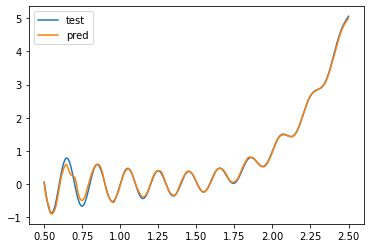

In [452]:
y_pred = model(x_test).detach().numpy()
plt.plot(np.loadtxt("test.txt")[:, :1], np.loadtxt("test.txt")[:, 1:], label='test')
plt.plot(np.loadtxt("test.txt")[:, :1], y_pred, label='pred')
plt.legend()

In [453]:
print(L2_error(y_pred, y_test.detach().numpy()))

[0.04509954]


In [454]:
np.savetxt("1D46.txt", y_pred)

### Data[0.3, 0.7]

In [455]:
model = Net().to(device)

server = Server(
    model=model,
    loss=criteria,
    optimizer=optimizer,
    n_client=n_client,
    chosen_prob=chosen_prob,
    optimizer_conf=optimizer_conf,
    local_batch_size=local_batch_size,
    local_epochs=local_epochs
)

clients = server.client_pool
ratio1 = [0.3, 0.7]
assign_data(ratio1, clients, dataloader = train_loader, assignment='alternating')


In [456]:
for epoch in range(epochs):
    server.aggregate()
    server.broadcast()
    with torch.no_grad():
        testloss = test(server.model)
    
    if epoch % 100 == 0:
        print("Epoch: {}, Overall_loss: {}, test_loss: {}".format(epoch, server.avg_loss, testloss))

/Users/apple/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-445-2b91ddb144e0>:6: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  test_loss += F.mse_loss(output.view(-1), target, reduction='sum').item()


Epoch: 0, Overall_loss: 1.0550353608670688, test_loss: 1760.41475
Epoch: 100, Overall_loss: 0.12534387631430513, test_loss: 3179.5615
Epoch: 200, Overall_loss: 0.1338854932359287, test_loss: 3471.81925
Epoch: 300, Overall_loss: 0.10714540639448733, test_loss: 3827.27375
Epoch: 400, Overall_loss: 0.12133758204678693, test_loss: 3771.142
Epoch: 500, Overall_loss: 0.10687352224652256, test_loss: 3875.6155
Epoch: 600, Overall_loss: 0.08547141930709283, test_loss: 4168.2065
Epoch: 700, Overall_loss: 0.03781918623662066, test_loss: 4229.62
Epoch: 800, Overall_loss: 0.11654607623460747, test_loss: 3545.65675
Epoch: 900, Overall_loss: 0.04601935922567334, test_loss: 4024.1265
Epoch: 1000, Overall_loss: 0.0392652532706658, test_loss: 3641.93675
Epoch: 1100, Overall_loss: 0.020121847456764607, test_loss: 3549.5145
Epoch: 1200, Overall_loss: 0.01982890072810863, test_loss: 3563.418
Epoch: 1300, Overall_loss: 0.0304182381590917, test_loss: 3675.737
Epoch: 1400, Overall_loss: 0.017863214731083384, 

Epoch: 11700, Overall_loss: 0.0017985620039066166, test_loss: 3369.10875
Epoch: 11800, Overall_loss: 0.003258110733267607, test_loss: 3468.33
Epoch: 11900, Overall_loss: 0.002118656610643181, test_loss: 3402.4
Epoch: 12000, Overall_loss: 0.007661390356675146, test_loss: 3459.974
Epoch: 12100, Overall_loss: 0.001673735480012727, test_loss: 3383.927
Epoch: 12200, Overall_loss: 0.0008348607232273069, test_loss: 3407.40525
Epoch: 12300, Overall_loss: 0.0004892508195986184, test_loss: 3410.05325
Epoch: 12400, Overall_loss: 0.0024162625084586794, test_loss: 3373.94575
Epoch: 12500, Overall_loss: 0.0011939549544227443, test_loss: 3513.67075
Epoch: 12600, Overall_loss: 0.0024412563424058525, test_loss: 3413.974
Epoch: 12700, Overall_loss: 0.0015433753557902363, test_loss: 3327.102
Epoch: 12800, Overall_loss: 0.006666427460524054, test_loss: 3293.48525
Epoch: 12900, Overall_loss: 0.0013974851005644137, test_loss: 3444.67075
Epoch: 13000, Overall_loss: 0.0012919064084555775, test_loss: 3478.1315

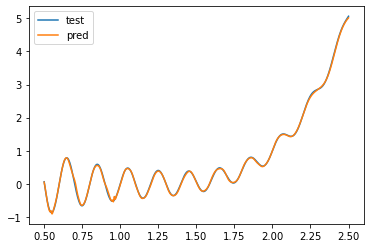

In [457]:
y_pred = model(x_test).detach().numpy()
plt.plot(np.loadtxt("test.txt")[:, :1], np.loadtxt("test.txt")[:, 1:], label='test')
plt.plot(np.loadtxt("test.txt")[:, :1], y_pred, label='pred')
plt.legend()

In [458]:
print(L2_error(y_pred, y_test.detach().numpy()))

[0.01671104]


In [459]:
np.savetxt("1D37.txt", y_pred)

## Repeat with random assignment

In [22]:
model = Net().to(device)

server = Server(
    model=model,
    loss=criteria,
    optimizer=optimizer,
    n_client=n_client,
    chosen_prob=chosen_prob,
    optimizer_conf=optimizer_conf,
    local_batch_size=local_batch_size,
    local_epochs=local_epochs
)

clients = server.client_pool
ratio1 = [0.5, 0.5]
assign_data(ratio1, clients, dataloader = train_loader, assignment='random')

for epoch in range(epochs):
    server.aggregate()
    server.broadcast()
    with torch.no_grad():
        testloss = test(server.model)
    
    if epoch % 100 == 0:
        print("Epoch: {}, Overall_loss: {}, test_loss: {}".format(epoch, server.avg_loss, testloss))

<ipython-input-21-ccd3278ef01b>:6: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  test_loss += F.mse_loss(output.view(-1), target, reduction='sum').item()


Epoch: 0, Overall_loss: 1.6862758815288543, test_loss: 1768.761625
Epoch: 100, Overall_loss: 0.0911070641130209, test_loss: 3299.3515
Epoch: 200, Overall_loss: 0.09195760637521744, test_loss: 3408.69
Epoch: 300, Overall_loss: 0.08738822508603333, test_loss: 3331.683
Epoch: 400, Overall_loss: 0.08264173287898302, test_loss: 3323.49425
Epoch: 500, Overall_loss: 0.08598450645804405, test_loss: 3243.8015
Epoch: 600, Overall_loss: 0.07087219841778278, test_loss: 3183.32125
Epoch: 700, Overall_loss: 0.06634240485727788, test_loss: 3268.84225
Epoch: 800, Overall_loss: 0.0618182310834527, test_loss: 3252.158
Epoch: 900, Overall_loss: 0.05533450460061431, test_loss: 3192.61125
Epoch: 1000, Overall_loss: 0.05061086611822248, test_loss: 3276.51825
Epoch: 1100, Overall_loss: 0.04388568382710219, test_loss: 3295.1445
Epoch: 1200, Overall_loss: 0.0385296024964191, test_loss: 3386.28175
Epoch: 1300, Overall_loss: 0.03586218087002635, test_loss: 3343.19225
Epoch: 1400, Overall_loss: 0.0342447833158075

Epoch: 11600, Overall_loss: 0.002028416155371815, test_loss: 3408.92925
Epoch: 11700, Overall_loss: 1.062366368387302e-05, test_loss: 3370.4785
Epoch: 11800, Overall_loss: 0.00042662103514885526, test_loss: 3365.2365
Epoch: 11900, Overall_loss: 4.656756464100908e-05, test_loss: 3381.18675
Epoch: 12000, Overall_loss: 3.853793086818769e-05, test_loss: 3371.758
Epoch: 12100, Overall_loss: 0.00020002959172416013, test_loss: 3381.00975
Epoch: 12200, Overall_loss: 0.0004350579753008787, test_loss: 3328.22425
Epoch: 12300, Overall_loss: 0.006317569874227047, test_loss: 3306.39975
Epoch: 12400, Overall_loss: 3.094290495937457e-05, test_loss: 3370.5745
Epoch: 12500, Overall_loss: 0.0002900697072618641, test_loss: 3375.759
Epoch: 12600, Overall_loss: 0.003861155634513125, test_loss: 3431.42
Epoch: 12700, Overall_loss: 5.001479148631915e-05, test_loss: 3359.898
Epoch: 12800, Overall_loss: 0.0003399566554435296, test_loss: 3381.3185
Epoch: 12900, Overall_loss: 0.0006706961372401566, test_loss: 335

[0.14663906]


/Users/apple/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


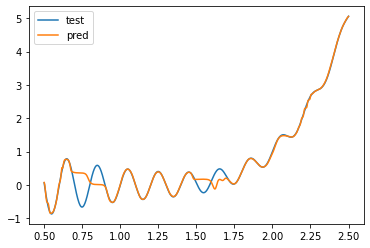

In [25]:
y_pred = model(x_test).detach().numpy()
plt.plot(np.loadtxt("test.txt")[:, :1], np.loadtxt("test.txt")[:, 1:], label='test')
plt.plot(np.loadtxt("test.txt")[:, :1], y_pred, label='pred')
plt.legend()
print(L2_error(y_pred, y_test.detach().numpy()))
np.savetxt("1D55_random.txt", y_pred)

In [26]:
model = Net().to(device)

server = Server(
    model=model,
    loss=criteria,
    optimizer=optimizer,
    n_client=n_client,
    chosen_prob=chosen_prob,
    optimizer_conf=optimizer_conf,
    local_batch_size=local_batch_size,
    local_epochs=local_epochs
)

clients = server.client_pool
ratio1 = [0.4, 0.6]
assign_data(ratio1, clients, dataloader = train_loader, assignment='random')

for epoch in range(epochs):
    server.aggregate()
    server.broadcast()
    with torch.no_grad():
        testloss = test(server.model)
    
    if epoch % 100 == 0:
        print("Epoch: {}, Overall_loss: {}, test_loss: {}".format(epoch, server.avg_loss, testloss))

/Users/apple/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-21-ccd3278ef01b>:6: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  test_loss += F.mse_loss(output.view(-1), target, reduction='sum').item()


Epoch: 0, Overall_loss: 1.7222350786129634, test_loss: 1761.924
Epoch: 100, Overall_loss: 0.10879886321102579, test_loss: 3299.0685
Epoch: 200, Overall_loss: 0.1019159946590662, test_loss: 3521.33475
Epoch: 300, Overall_loss: 0.1009613248364379, test_loss: 3463.40125
Epoch: 400, Overall_loss: 0.1012612592894584, test_loss: 3382.3445
Epoch: 500, Overall_loss: 0.09979700700690348, test_loss: 3438.82775
Epoch: 600, Overall_loss: 0.09643965555975835, test_loss: 3289.54025
Epoch: 700, Overall_loss: 0.08972619163493316, test_loss: 3309.93825
Epoch: 800, Overall_loss: 0.07296385709196329, test_loss: 3383.803
Epoch: 900, Overall_loss: 0.059536409098654985, test_loss: 3244.278
Epoch: 1000, Overall_loss: 0.031172245740890503, test_loss: 2999.10775
Epoch: 1100, Overall_loss: 0.018028885727593057, test_loss: 3418.989
Epoch: 1200, Overall_loss: 0.017226981231942773, test_loss: 3416.8895
Epoch: 1300, Overall_loss: 0.009614682368313272, test_loss: 3386.13
Epoch: 1400, Overall_loss: 0.0072527213075469

Epoch: 11700, Overall_loss: 7.179627467242729e-05, test_loss: 3424.6335
Epoch: 11800, Overall_loss: 0.002904301923535968, test_loss: 3389.57675
Epoch: 11900, Overall_loss: 0.00012160199003119487, test_loss: 3398.601
Epoch: 12000, Overall_loss: 0.0004069677433259737, test_loss: 3372.085
Epoch: 12100, Overall_loss: 0.004436106246430427, test_loss: 3460.72025
Epoch: 12200, Overall_loss: 2.8955766576170088e-05, test_loss: 3423.57625
Epoch: 12300, Overall_loss: 0.002898222025275269, test_loss: 3304.85825
Epoch: 12400, Overall_loss: 0.0014811546777006395, test_loss: 3394.6925
Epoch: 12500, Overall_loss: 0.0005750080769454751, test_loss: 3450.552
Epoch: 12600, Overall_loss: 9.22823390586321e-05, test_loss: 3437.27925
Epoch: 12700, Overall_loss: 6.571694560382942e-05, test_loss: 3417.9505
Epoch: 12800, Overall_loss: 7.532845711466507e-05, test_loss: 3405.02
Epoch: 12900, Overall_loss: 0.00040117831031238893, test_loss: 3391.7615
Epoch: 13000, Overall_loss: 0.0005935352943803688, test_loss: 337

[0.08525898]


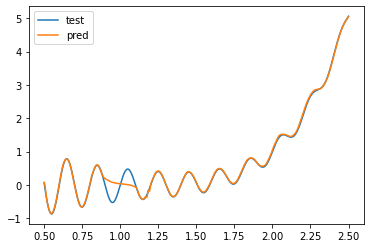

In [27]:
y_pred = model(x_test).detach().numpy()
plt.plot(np.loadtxt("test.txt")[:, :1], np.loadtxt("test.txt")[:, 1:], label='test')
plt.plot(np.loadtxt("test.txt")[:, :1], y_pred, label='pred')
plt.legend()
print(L2_error(y_pred, y_test.detach().numpy()))
np.savetxt("1D46_random.txt", y_pred)

In [28]:
model = Net().to(device)

server = Server(
    model=model,
    loss=criteria,
    optimizer=optimizer,
    n_client=n_client,
    chosen_prob=chosen_prob,
    optimizer_conf=optimizer_conf,
    local_batch_size=local_batch_size,
    local_epochs=local_epochs
)

clients = server.client_pool
ratio1 = [0.3, 0.7]
assign_data(ratio1, clients, dataloader = train_loader, assignment='random')

for epoch in range(epochs):
    server.aggregate()
    server.broadcast()
    with torch.no_grad():
        testloss = test(server.model)
    
    if epoch % 100 == 0:
        print("Epoch: {}, Overall_loss: {}, test_loss: {}".format(epoch, server.avg_loss, testloss))

Epoch: 0, Overall_loss: 1.1020347163790747, test_loss: 1760.4875


/Users/apple/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-21-ccd3278ef01b>:6: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  test_loss += F.mse_loss(output.view(-1), target, reduction='sum').item()


Epoch: 100, Overall_loss: 0.12653360852882975, test_loss: 3719.297
Epoch: 200, Overall_loss: 0.12256439934883799, test_loss: 3961.36575
Epoch: 300, Overall_loss: 0.0972522341956695, test_loss: 3623.6645
Epoch: 400, Overall_loss: 0.08961883333644696, test_loss: 3588.06225
Epoch: 500, Overall_loss: 0.06641242378169582, test_loss: 3486.21575
Epoch: 600, Overall_loss: 0.0679666931253104, test_loss: 3506.936
Epoch: 700, Overall_loss: 0.04996713632274241, test_loss: 3249.6545
Epoch: 800, Overall_loss: 0.039092606731823513, test_loss: 3356.48475
Epoch: 900, Overall_loss: 0.035935464093372935, test_loss: 3247.83575
Epoch: 1000, Overall_loss: 0.03554571871202262, test_loss: 3225.847
Epoch: 1100, Overall_loss: 0.03638731865655808, test_loss: 3215.26675
Epoch: 1200, Overall_loss: 0.03150610887401161, test_loss: 3270.69525
Epoch: 1300, Overall_loss: 0.03643750195347127, test_loss: 3130.75275
Epoch: 1400, Overall_loss: 0.03263930830040149, test_loss: 3138.908
Epoch: 1500, Overall_loss: 0.0314133816

Epoch: 11700, Overall_loss: 0.0008577421706702028, test_loss: 3452.35525
Epoch: 11800, Overall_loss: 0.0001509746724055038, test_loss: 3415.4415
Epoch: 11900, Overall_loss: 0.000571905290209023, test_loss: 3440.4875
Epoch: 12000, Overall_loss: 0.022371542495204177, test_loss: 3544.8035
Epoch: 12100, Overall_loss: 0.0032822581637273764, test_loss: 3480.12575
Epoch: 12200, Overall_loss: 0.0036171189636834676, test_loss: 3435.72425
Epoch: 12300, Overall_loss: 0.010473396202238897, test_loss: 3350.703
Epoch: 12400, Overall_loss: 0.004147865896811709, test_loss: 3433.7275
Epoch: 12500, Overall_loss: 0.0036984449973152507, test_loss: 3436.724
Epoch: 12600, Overall_loss: 0.0025717613247079065, test_loss: 3420.535
Epoch: 12700, Overall_loss: 0.0031044429886692556, test_loss: 3505.6745
Epoch: 12800, Overall_loss: 0.0009608553501450279, test_loss: 3440.3065
Epoch: 12900, Overall_loss: 0.0022616166201519915, test_loss: 3434.92575
Epoch: 13000, Overall_loss: 0.0003583560953432295, test_loss: 3409.

[0.06668579]


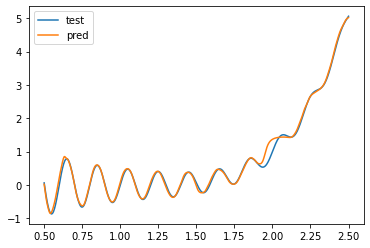

In [29]:
y_pred = model(x_test).detach().numpy()
plt.plot(np.loadtxt("test.txt")[:, :1], np.loadtxt("test.txt")[:, 1:], label='test')
plt.plot(np.loadtxt("test.txt")[:, :1], y_pred, label='pred')
plt.legend()
print(L2_error(y_pred, y_test.detach().numpy()))
np.savetxt("1D37_random.txt", y_pred)

## Repeat with sequential assignment

In [30]:
model = Net().to(device)

server = Server(
    model=model,
    loss=criteria,
    optimizer=optimizer,
    n_client=n_client,
    chosen_prob=chosen_prob,
    optimizer_conf=optimizer_conf,
    local_batch_size=local_batch_size,
    local_epochs=local_epochs
)

clients = server.client_pool
ratio1 = [0.5, 0.5]
assign_data(ratio1, clients, dataloader = train_loader, assignment='random')

for epoch in range(epochs):
    server.aggregate()
    server.broadcast()
    with torch.no_grad():
        testloss = test(server.model)
    
    if epoch % 100 == 0:
        print("Epoch: {}, Overall_loss: {}, test_loss: {}".format(epoch, server.avg_loss, testloss))

/Users/apple/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-21-ccd3278ef01b>:6: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  test_loss += F.mse_loss(output.view(-1), target, reduction='sum').item()


Epoch: 0, Overall_loss: 1.6121653735637664, test_loss: 1802.70725
Epoch: 100, Overall_loss: 0.08877947367727757, test_loss: 3385.2295
Epoch: 200, Overall_loss: 0.08557024002075195, test_loss: 3451.71825
Epoch: 300, Overall_loss: 0.08667273335158825, test_loss: 3383.785
Epoch: 400, Overall_loss: 0.08537006676197052, test_loss: 3405.1605
Epoch: 500, Overall_loss: 0.07918419577181339, test_loss: 3476.32725
Epoch: 600, Overall_loss: 0.05793303642421961, test_loss: 3335.2825
Epoch: 700, Overall_loss: 0.04553214497864247, test_loss: 3373.96225
Epoch: 800, Overall_loss: 0.037309907004237176, test_loss: 3412.3215
Epoch: 900, Overall_loss: 0.03641976178623736, test_loss: 3385.99375
Epoch: 1000, Overall_loss: 0.04043191303499043, test_loss: 3400.33025
Epoch: 1100, Overall_loss: 0.0329571770154871, test_loss: 3413.1555
Epoch: 1200, Overall_loss: 0.038282561115920544, test_loss: 3390.83025
Epoch: 1300, Overall_loss: 0.036183037469163536, test_loss: 3334.97775
Epoch: 1400, Overall_loss: 0.039528296

Epoch: 11600, Overall_loss: 0.00023586930328747257, test_loss: 3411.987
Epoch: 11700, Overall_loss: 4.6033619992158495e-05, test_loss: 3450.3855
Epoch: 11800, Overall_loss: 0.0027596072730375456, test_loss: 3439.7165
Epoch: 11900, Overall_loss: 0.0010791834618430584, test_loss: 3440.27575
Epoch: 12000, Overall_loss: 0.0004728927233372815, test_loss: 3422.98975
Epoch: 12100, Overall_loss: 0.0001481537781728548, test_loss: 3452.17675
Epoch: 12200, Overall_loss: 0.0010862225826713257, test_loss: 3457.37725
Epoch: 12300, Overall_loss: 0.0024512840529496314, test_loss: 3462.7755
Epoch: 12400, Overall_loss: 0.00014495666764560155, test_loss: 3440.77075
Epoch: 12500, Overall_loss: 0.00042725662933662534, test_loss: 3429.193
Epoch: 12600, Overall_loss: 3.487344129098347e-05, test_loss: 3442.352
Epoch: 12700, Overall_loss: 0.0006425765837775542, test_loss: 3445.79225
Epoch: 12800, Overall_loss: 0.000156294754560804, test_loss: 3440.217
Epoch: 12900, Overall_loss: 0.0002607023991004098, test_los

[0.13711226]


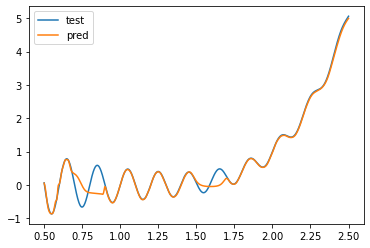

In [31]:
y_pred = model(x_test).detach().numpy()
plt.plot(np.loadtxt("test.txt")[:, :1], np.loadtxt("test.txt")[:, 1:], label='test')
plt.plot(np.loadtxt("test.txt")[:, :1], y_pred, label='pred')
plt.legend()
print(L2_error(y_pred, y_test.detach().numpy()))
np.savetxt("1D55_sequential.txt", y_pred)

In [32]:
model = Net().to(device)

server = Server(
    model=model,
    loss=criteria,
    optimizer=optimizer,
    n_client=n_client,
    chosen_prob=chosen_prob,
    optimizer_conf=optimizer_conf,
    local_batch_size=local_batch_size,
    local_epochs=local_epochs
)

clients = server.client_pool
ratio1 = [0.4, 0.6]
assign_data(ratio1, clients, dataloader = train_loader, assignment='random')

for epoch in range(epochs):
    server.aggregate()
    server.broadcast()
    with torch.no_grad():
        testloss = test(server.model)
    
    if epoch % 100 == 0:
        print("Epoch: {}, Overall_loss: {}, test_loss: {}".format(epoch, server.avg_loss, testloss))

/Users/apple/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-21-ccd3278ef01b>:6: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  test_loss += F.mse_loss(output.view(-1), target, reduction='sum').item()


Epoch: 0, Overall_loss: 1.7200600802898407, test_loss: 1759.729125
Epoch: 100, Overall_loss: 0.13043150026351213, test_loss: 3183.3945
Epoch: 200, Overall_loss: 0.12597694310049215, test_loss: 3348.5705
Epoch: 300, Overall_loss: 0.11881948479761681, test_loss: 3401.22125
Epoch: 400, Overall_loss: 0.10347388063867888, test_loss: 3377.258
Epoch: 500, Overall_loss: 0.05458547594025731, test_loss: 3351.08525
Epoch: 600, Overall_loss: 0.031669160739208266, test_loss: 3332.4865
Epoch: 700, Overall_loss: 0.017713131654697158, test_loss: 3315.38825
Epoch: 800, Overall_loss: 0.013246874848846346, test_loss: 3311.868
Epoch: 900, Overall_loss: 0.0042481575947022066, test_loss: 3346.609
Epoch: 1000, Overall_loss: 0.002766755297974062, test_loss: 3313.253
Epoch: 1100, Overall_loss: 0.009470500158689294, test_loss: 3283.13
Epoch: 1200, Overall_loss: 0.0058445735000229124, test_loss: 3289.68225
Epoch: 1300, Overall_loss: 0.0027495875062110526, test_loss: 3399.22425
Epoch: 1400, Overall_loss: 0.004650

Epoch: 11600, Overall_loss: 0.0011202070951791636, test_loss: 3346.81625
Epoch: 11700, Overall_loss: 0.00040787951274978695, test_loss: 3356.35075
Epoch: 11800, Overall_loss: 0.0009864640827193702, test_loss: 3355.70675
Epoch: 11900, Overall_loss: 4.4847514989972595e-05, test_loss: 3371.35175
Epoch: 12000, Overall_loss: 9.254830604277231e-05, test_loss: 3378.58575
Epoch: 12100, Overall_loss: 0.0005926481220133912, test_loss: 3362.328
Epoch: 12200, Overall_loss: 0.0002992711233673617, test_loss: 3345.965
Epoch: 12300, Overall_loss: 0.0017358899785904214, test_loss: 3338.51325
Epoch: 12400, Overall_loss: 0.00040675549826119095, test_loss: 3352.828
Epoch: 12500, Overall_loss: 3.178697452691874e-05, test_loss: 3372.47
Epoch: 12600, Overall_loss: 0.0031717406624617674, test_loss: 3368.1915
Epoch: 12700, Overall_loss: 2.7266803461619322e-05, test_loss: 3372.05325
Epoch: 12800, Overall_loss: 2.7503058220190724e-05, test_loss: 3373.19325
Epoch: 12900, Overall_loss: 8.711912444899403e-05, test_

[0.12090711]


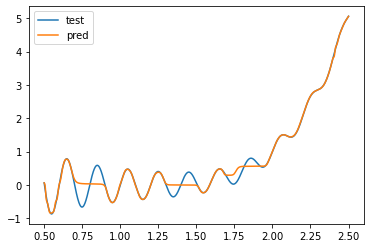

In [33]:
y_pred = model(x_test).detach().numpy()
plt.plot(np.loadtxt("test.txt")[:, :1], np.loadtxt("test.txt")[:, 1:], label='test')
plt.plot(np.loadtxt("test.txt")[:, :1], y_pred, label='pred')
plt.legend()
print(L2_error(y_pred, y_test.detach().numpy()))
np.savetxt("1D46_sequential.txt", y_pred)

In [34]:
model = Net().to(device)

server = Server(
    model=model,
    loss=criteria,
    optimizer=optimizer,
    n_client=n_client,
    chosen_prob=chosen_prob,
    optimizer_conf=optimizer_conf,
    local_batch_size=local_batch_size,
    local_epochs=local_epochs
)

clients = server.client_pool
ratio1 = [0.3, 0.7]
assign_data(ratio1, clients, dataloader = train_loader, assignment='random')

for epoch in range(epochs):
    server.aggregate()
    server.broadcast()
    with torch.no_grad():
        testloss = test(server.model)
    
    if epoch % 100 == 0:
        print("Epoch: {}, Overall_loss: {}, test_loss: {}".format(epoch, server.avg_loss, testloss))

/Users/apple/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-21-ccd3278ef01b>:6: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  test_loss += F.mse_loss(output.view(-1), target, reduction='sum').item()


Epoch: 0, Overall_loss: 0.34999248314471476, test_loss: 1869.592
Epoch: 100, Overall_loss: 0.12968099081800097, test_loss: 2843.3835
Epoch: 200, Overall_loss: 0.1051225077715658, test_loss: 2940.7775
Epoch: 300, Overall_loss: 0.10417049342677706, test_loss: 2836.67725
Epoch: 400, Overall_loss: 0.09712610925946917, test_loss: 2742.24975
Epoch: 500, Overall_loss: 0.0921449986774297, test_loss: 2807.78675
Epoch: 600, Overall_loss: 0.09553415221827372, test_loss: 2821.74275
Epoch: 700, Overall_loss: 0.028203739829006647, test_loss: 2859.1025
Epoch: 800, Overall_loss: 0.005375678150206416, test_loss: 2912.81625
Epoch: 900, Overall_loss: 0.002083501108028854, test_loss: 2907.88925
Epoch: 1000, Overall_loss: 0.002638312704567354, test_loss: 2850.58825
Epoch: 1100, Overall_loss: 0.0008757040860863137, test_loss: 2902.59425
Epoch: 1200, Overall_loss: 0.00044992299185001424, test_loss: 2891.877
Epoch: 1300, Overall_loss: 0.0026063728201690885, test_loss: 2846.64425
Epoch: 1400, Overall_loss: 0.0

Epoch: 11500, Overall_loss: 0.0009069189393249829, test_loss: 2790.65075
Epoch: 11600, Overall_loss: 9.164587481791386e-06, test_loss: 2779.53325
Epoch: 11700, Overall_loss: 0.0009534461732116706, test_loss: 2786.2315
Epoch: 11800, Overall_loss: 5.1271506479332904e-05, test_loss: 2782.39025
Epoch: 11900, Overall_loss: 0.01672596941768591, test_loss: 2841.154
Epoch: 12000, Overall_loss: 5.938047966732743e-06, test_loss: 2785.0135
Epoch: 12100, Overall_loss: 1.3212032562088488e-05, test_loss: 2785.6565
Epoch: 12200, Overall_loss: 4.523271573340199e-05, test_loss: 2785.148
Epoch: 12300, Overall_loss: 2.5559334051736404e-05, test_loss: 2788.7085
Epoch: 12400, Overall_loss: 5.863884195735279e-06, test_loss: 2786.68575
Epoch: 12500, Overall_loss: 5.023076001618522e-06, test_loss: 2786.509
Epoch: 12600, Overall_loss: 0.0008399149143466881, test_loss: 2783.1535
Epoch: 12700, Overall_loss: 3.933036526047674e-06, test_loss: 2789.377
Epoch: 12800, Overall_loss: 0.00019305821175900442, test_loss: 

[0.2807623]


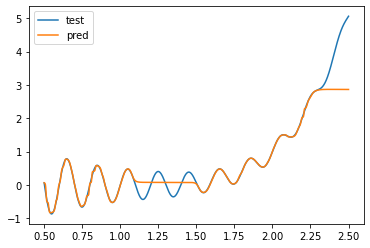

In [35]:
y_pred = model(x_test).detach().numpy()
plt.plot(np.loadtxt("test.txt")[:, :1], np.loadtxt("test.txt")[:, 1:], label='test')
plt.plot(np.loadtxt("test.txt")[:, :1], y_pred, label='pred')
plt.legend()
print(L2_error(y_pred, y_test.detach().numpy()))
np.savetxt("1D37_sequential.txt", y_pred)

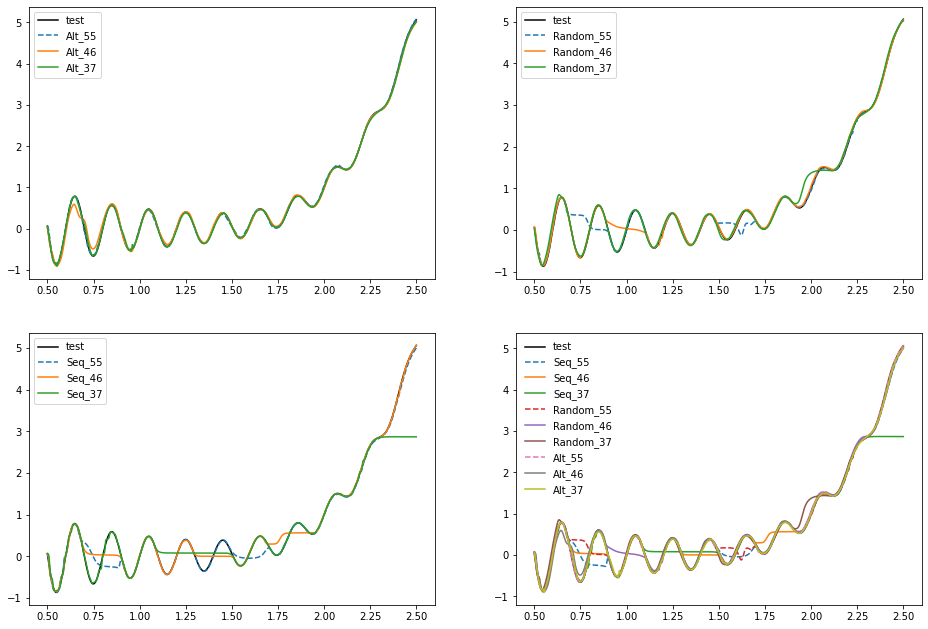

In [55]:
plt.figure(figsize=(16,11))

plt.subplot(221)
plt.plot(np.loadtxt("test.txt")[:, :1], np.loadtxt("test.txt")[:, 1:], color='black', label='test')
plt.plot(np.loadtxt("test.txt")[:, :1], np.loadtxt("1D55.txt"),'--', label='Alt_55')
plt.plot(np.loadtxt("test.txt")[:, :1], np.loadtxt("1D46.txt"), label='Alt_46')
plt.plot(np.loadtxt("test.txt")[:, :1], np.loadtxt("1D37.txt"), label='Alt_37')
plt.legend()

plt.subplot(223)
plt.plot(np.loadtxt("test.txt")[:, :1], np.loadtxt("test.txt")[:, 1:], color='black', label='test')
plt.plot(np.loadtxt("test.txt")[:, :1], np.loadtxt("1D55_sequential.txt"),'--', label='Seq_55')
plt.plot(np.loadtxt("test.txt")[:, :1], np.loadtxt("1D46_sequential.txt"), label='Seq_46')
plt.plot(np.loadtxt("test.txt")[:, :1], np.loadtxt("1D37_sequential.txt"), label='Seq_37')
plt.legend()

plt.subplot(222)
plt.plot(np.loadtxt("test.txt")[:, :1], np.loadtxt("test.txt")[:, 1:], color='black', label='test')
plt.plot(np.loadtxt("test.txt")[:, :1], np.loadtxt("1D55_random.txt"), '--',label='Random_55')
plt.plot(np.loadtxt("test.txt")[:, :1], np.loadtxt("1D46_random.txt"), label='Random_46')
plt.plot(np.loadtxt("test.txt")[:, :1], np.loadtxt("1D37_random.txt"), label='Random_37')
plt.legend()

plt.subplot(224)
# plt.figure(figsize=(12,8))
plt.plot(np.loadtxt("test.txt")[:, :1], np.loadtxt("test.txt")[:, 1:], color='black', label='test')
plt.plot(np.loadtxt("test.txt")[:, :1], np.loadtxt("1D55_sequential.txt"),'--', label='Seq_55')
plt.plot(np.loadtxt("test.txt")[:, :1], np.loadtxt("1D46_sequential.txt"), label='Seq_46')
plt.plot(np.loadtxt("test.txt")[:, :1], np.loadtxt("1D37_sequential.txt"), label='Seq_37')
plt.plot(np.loadtxt("test.txt")[:, :1], np.loadtxt("1D55_random.txt"), '--',label='Random_55')
plt.plot(np.loadtxt("test.txt")[:, :1], np.loadtxt("1D46_random.txt"), label='Random_46')
plt.plot(np.loadtxt("test.txt")[:, :1], np.loadtxt("1D37_random.txt"), label='Random_37')
plt.plot(np.loadtxt("test.txt")[:, :1], np.loadtxt("1D55.txt"),'--', label='Alt_55')
plt.plot(np.loadtxt("test.txt")[:, :1], np.loadtxt("1D46.txt"), label='Alt_46')
plt.plot(np.loadtxt("test.txt")[:, :1], np.loadtxt("1D37.txt"), label='Alt_37')
plt.legend(frameon=False)



In [58]:
alt = np.zeros(3)
ran = np.zeros(3)
seq = np.zeros(3)

ratio = ['55', '46', '37']
y_test = np.loadtxt("test.txt")[:, 1:]
for i in range(len(ratio)):
    y_pred = np.loadtxt("1D{}.txt".format(ratio[i]))
    alt[i] = L2_error(y_pred, y_test)
    
for i in range(len(ratio)):
    y_pred = np.loadtxt("1D{}_Random.txt".format(ratio[i]))
    ran[i] = L2_error(y_pred, y_test)
    
for i in range(len(ratio)):
    y_pred = np.loadtxt("1D{}_Sequential.txt".format(ratio[i]))
    seq[i] = L2_error(y_pred, y_test)

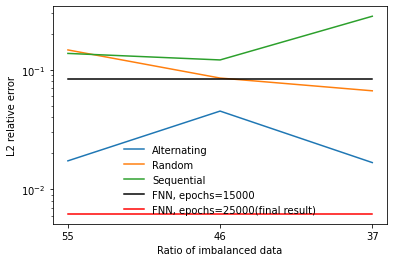

In [76]:
plt.semilogy(ratio, alt, label='Alternating')
plt.semilogy(ratio, ran, label='Random')
plt.semilogy(ratio, seq, label='Sequential')
plt.semilogy(ratio, np.repeat(8.37e-02,3), color='black',label = 'FNN, epochs=15000')
plt.semilogy(ratio, np.repeat(6.21e-03,3), color='red',label = 'FNN, epochs=25000(final result)')
plt.xlabel("Ratio of imbalanced data")
plt.ylabel("L2 relative error")
plt.legend(frameon=False)

## More Clients

In [77]:
# initialize parameters
torch.manual_seed(1)
n_client = 3
chosen_prob = 1
local_batch_size = 10
local_epochs = 3
epochs =15000
criteria = nn.MSELoss()
optimizer = optim.Adam
optimizer_conf = dict(
    lr=0.001,
#     momentum=0.9
)

In [79]:
model = Net().to(device)

server = Server(
    model=model,
    loss=criteria,
    optimizer=optimizer,
    n_client=n_client,
    chosen_prob=chosen_prob,
    optimizer_conf=optimizer_conf,
    local_batch_size=local_batch_size,
    local_epochs=local_epochs
)

clients = server.client_pool
ratio1 = [0.4, 0.3, 0.3]
assign_data(ratio1, clients, dataloader = train_loader, assignment='alternating')

for epoch in range(epochs):
    server.aggregate()
    server.broadcast()
    with torch.no_grad():
        testloss = test(server.model)
    
    if epoch % 100 == 0:
        print("Epoch: {}, Overall_loss: {}, test_loss: {}".format(epoch, server.avg_loss, testloss))

/Users/apple/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-21-ccd3278ef01b>:6: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  test_loss += F.mse_loss(output.view(-1), target, reduction='sum').item()


Epoch: 0, Overall_loss: 1.4275105728043451, test_loss: 1728.6345
Epoch: 100, Overall_loss: 0.11051997542381287, test_loss: 3545.4955
Epoch: 200, Overall_loss: 0.09814447806113295, test_loss: 3516.3365
Epoch: 300, Overall_loss: 0.09585483848220772, test_loss: 3656.10375
Epoch: 400, Overall_loss: 0.10208588942057557, test_loss: 3496.49725
Epoch: 500, Overall_loss: 0.08677354858567317, test_loss: 3599.6785
Epoch: 600, Overall_loss: 0.0811011375238498, test_loss: 3609.4725
Epoch: 700, Overall_loss: 0.07787983191923963, test_loss: 3563.7405
Epoch: 800, Overall_loss: 0.06983630234996478, test_loss: 3577.587
Epoch: 900, Overall_loss: 0.07229753314620918, test_loss: 3510.0585
Epoch: 1000, Overall_loss: 0.05868784746982985, test_loss: 3560.47525
Epoch: 1100, Overall_loss: 0.0566465909489327, test_loss: 3517.6385
Epoch: 1200, Overall_loss: 0.046484619896445006, test_loss: 3514.49925
Epoch: 1300, Overall_loss: 0.032540922829260424, test_loss: 3509.55625
Epoch: 1400, Overall_loss: 0.02735188911255

Epoch: 11700, Overall_loss: 0.0008768214619420986, test_loss: 3441.16625
Epoch: 11800, Overall_loss: 0.001909143587302727, test_loss: 3469.29825
Epoch: 11900, Overall_loss: 0.0021895761294419775, test_loss: 3425.578
Epoch: 12000, Overall_loss: 0.002105929694759349, test_loss: 3481.54775
Epoch: 12100, Overall_loss: 0.0009760077049981596, test_loss: 3452.896
Epoch: 12200, Overall_loss: 0.0010434378677422905, test_loss: 3409.782
Epoch: 12300, Overall_loss: 0.0016979226493276654, test_loss: 3429.8855
Epoch: 12400, Overall_loss: 0.0021568344915673756, test_loss: 3448.894
Epoch: 12500, Overall_loss: 0.0015294577784111928, test_loss: 3462.2125
Epoch: 12600, Overall_loss: 0.0021664695426200824, test_loss: 3457.344
Epoch: 12700, Overall_loss: 0.0009820354882524244, test_loss: 3480.77775
Epoch: 12800, Overall_loss: 0.004866929808890239, test_loss: 3414.6485
Epoch: 12900, Overall_loss: 0.0019285344072462371, test_loss: 3402.873
Epoch: 13000, Overall_loss: 0.0056823984616332585, test_loss: 3607.15

[0.02957551]


/Users/apple/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


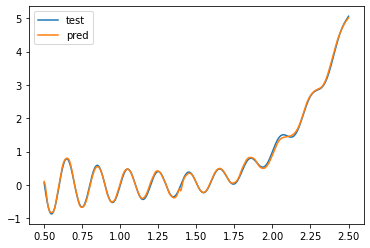

In [81]:
y_pred = model(x_test).detach().numpy()
plt.plot(np.loadtxt("test.txt")[:, :1], np.loadtxt("test.txt")[:, 1:], label='test')
plt.plot(np.loadtxt("test.txt")[:, :1], y_pred, label='pred')
plt.legend()
print(L2_error(y_pred, y_test))
np.savetxt("1D433.txt", y_pred)

In [84]:
model = Net().to(device)

server = Server(
    model=model,
    loss=criteria,
    optimizer=optimizer,
    n_client=n_client,
    chosen_prob=chosen_prob,
    optimizer_conf=optimizer_conf,
    local_batch_size=local_batch_size,
    local_epochs=local_epochs
)

clients = server.client_pool
ratio1 = [0.2, 0.3, 0.5]
assign_data(ratio1, clients, dataloader = train_loader, assignment='alternating')

for epoch in range(epochs):
    server.aggregate()
    server.broadcast()
    with torch.no_grad():
        testloss = test(server.model)
    
    if epoch % 100 == 0:
        print("Epoch: {}, Overall_loss: {}, test_loss: {}".format(epoch, server.avg_loss, testloss))

/Users/apple/opt/anaconda3/lib/python3.8/site-packages/torch/nn/functional.py:1340: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
<ipython-input-21-ccd3278ef01b>:6: UserWarning: Using a target size (torch.Size([1000, 1])) that is different to the input size (torch.Size([1000])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  test_loss += F.mse_loss(output.view(-1), target, reduction='sum').item()


Epoch: 0, Overall_loss: 0.9309655987554125, test_loss: 1811.78075
Epoch: 100, Overall_loss: 0.12795809143119388, test_loss: 3670.92775
Epoch: 200, Overall_loss: 0.12466900191373294, test_loss: 3607.1225
Epoch: 300, Overall_loss: 0.11334154042932722, test_loss: 3854.20175
Epoch: 400, Overall_loss: 0.11452793421016799, test_loss: 3636.99375
Epoch: 500, Overall_loss: 0.09218907347983785, test_loss: 3921.5195
Epoch: 600, Overall_loss: 0.13090219994386035, test_loss: 3893.912
Epoch: 700, Overall_loss: 0.08567489890588655, test_loss: 4204.7875
Epoch: 800, Overall_loss: 0.08238555652399857, test_loss: 4260.573
Epoch: 900, Overall_loss: 0.08209733333852556, test_loss: 4269.079
Epoch: 1000, Overall_loss: 0.05816991428534189, test_loss: 4160.6485
Epoch: 1100, Overall_loss: 0.047978928085002634, test_loss: 3930.51775
Epoch: 1200, Overall_loss: 0.029464999938176736, test_loss: 3801.987
Epoch: 1300, Overall_loss: 0.02917988708035813, test_loss: 3871.26925
Epoch: 1400, Overall_loss: 0.01605194964342

Epoch: 11700, Overall_loss: 0.0015441636638974564, test_loss: 3452.3035
Epoch: 11800, Overall_loss: 0.00011910398170584811, test_loss: 3433.5205
Epoch: 11900, Overall_loss: 0.0007595285834718702, test_loss: 3406.825
Epoch: 12000, Overall_loss: 0.0007268359376919559, test_loss: 3428.8485
Epoch: 12100, Overall_loss: 0.0068476559665416265, test_loss: 3396.3745
Epoch: 12200, Overall_loss: 0.00019411666176488829, test_loss: 3418.92725
Epoch: 12300, Overall_loss: 0.0005178698488938001, test_loss: 3418.8195
Epoch: 12400, Overall_loss: 0.0006415303705984518, test_loss: 3407.671
Epoch: 12500, Overall_loss: 0.0038806973982395397, test_loss: 3402.32625
Epoch: 12600, Overall_loss: 0.003702311674391644, test_loss: 3418.28
Epoch: 12700, Overall_loss: 0.003236247374055286, test_loss: 3407.96075
Epoch: 12800, Overall_loss: 0.0008961619767231038, test_loss: 3433.6915
Epoch: 12900, Overall_loss: 0.001133754919283092, test_loss: 3446.95225
Epoch: 13000, Overall_loss: 0.0008694314908805406, test_loss: 340

In [ ]:
y_pred = model(x_test).detach().numpy()
plt.plot(np.loadtxt("test.txt")[:, :1], np.loadtxt("test.txt")[:, 1:], label='test')
plt.plot(np.loadtxt("test.txt")[:, :1], y_pred, label='pred')
plt.legend()
print(L2_error(y_pred, y_test.detach().numpy()))
np.savetxt("1D532.txt", y_pred)